# Gyroscope Model Validation

## Import

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp

import gym_gyroscope_env
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import prbs
import torch

import matplotlib.pyplot as plt
%matplotlib inline

## Environment Class and Modules

In [2]:
# Initialization args
env_name = 'GyroscopeEnv-v0'
state = np.zeros([7])
simu_args = {
    'dt': 0.02,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Normalized'
reward_args = {
    'k': 0.05, 
    'qx2': 0.01, 
    'qx4': 0.01, 
    'pu1': 0.5, 
    'pu2': 0.5
}

# Create env
env = create_env(env_name,simu_args,reward_func,reward_args, state)

# Create another env with friction
simu_args['friction'] = True
env_f = create_env(env_name,simu_args,reward_func,reward_args, state)

## Helpful funciton

In [3]:
u = prbs(10,10)
np.savetxt('prbs.txt', u, delimiter=',')

In [4]:
def read_data(filepath):
    
    # count lines
    file = open(filepath, "r")
    count = len(file.readlines(  ))
    data = np.empty([count, 16])
    file.seek(0)
    
    # read each line as a numpy array
    row = 0
    for x in file:
        data[row] = np.array(x.split('\t')).astype(np.float)
        row += 1
    file.close()
    
    # change time from usec into sec and shift the beginning to 0
    data[:,11] = data[:,11] / 1e6
    data[:,11] -= data[0,11]
    
    return data

# Red gimbal in virtual env（no friction）

In [5]:
# Initial state
x_0 = [0,0,0,0,0,0,0]
observation = env.reset(x_0)

time = np.arange(0, 60, env.dt)
state_record = np.empty([len(time), len(x_0)])
reward_record = np.empty([len(time), 1])
action_record = np.empty([len(time), 2])

for i in range(len(time)):
    action = [u[i],0] 
    
    observation, reward, done, info = env.step(action)
    state_record[i] = env.state
    reward_record[i] = reward
    action_record[i] = action

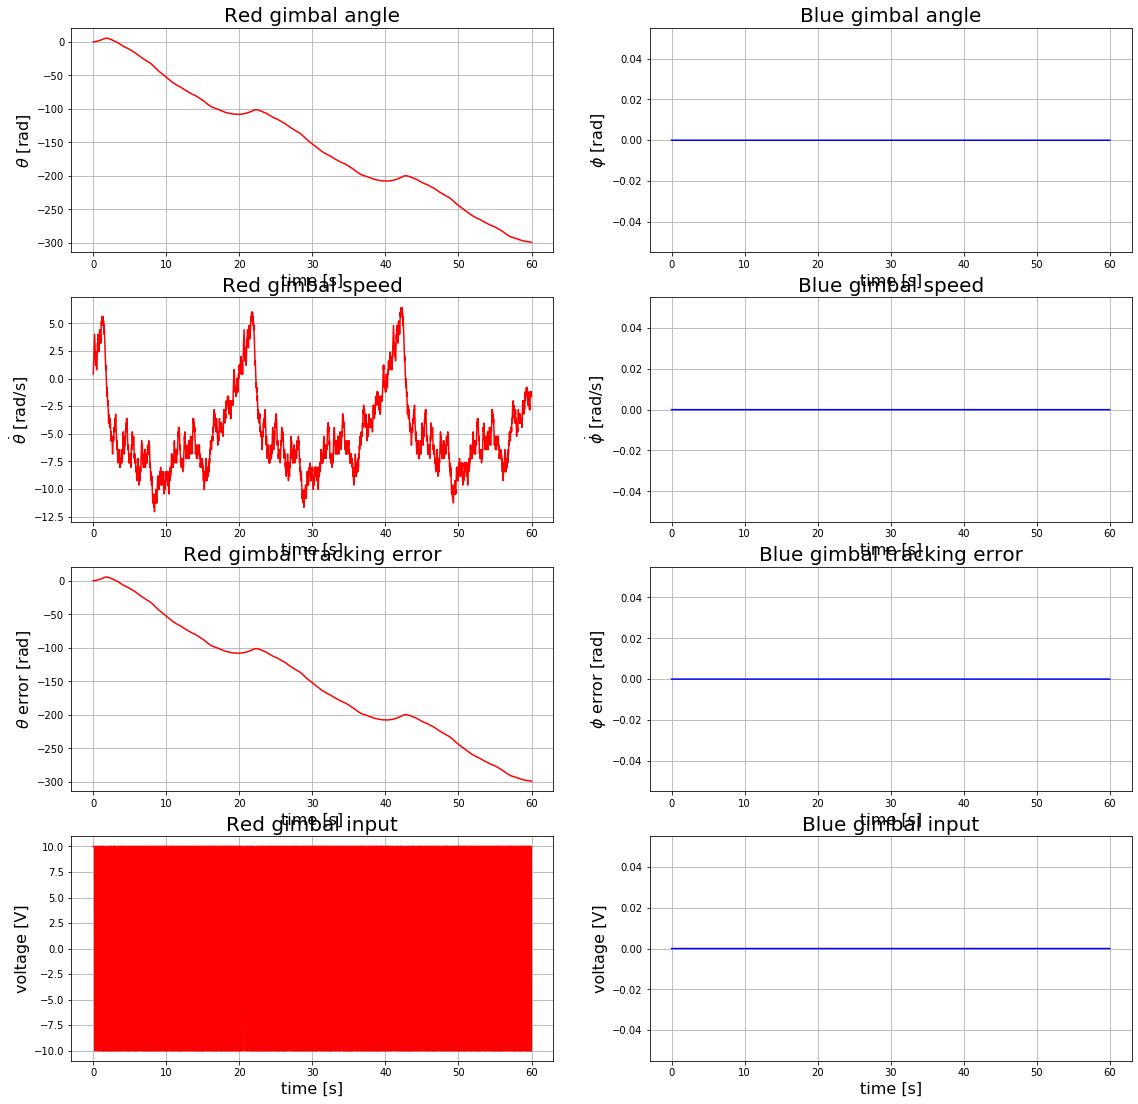

In [6]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0],'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2],'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1],'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3],'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0]-state_record[:,4],'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2]-state_record[:,5],'b-')

plt.subplot(4,2,7)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,0]*10,'r-')

plt.subplot(4,2,8)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,1]*10,'b-')

plt.show()

# Red gimbal in virtual env（with friction）

In [7]:
# Initial state
x_0 = [0,0,0,0,0,0,0]
observation = env_f.reset(x_0)

time = np.arange(0, 60, env.dt)
state_record_f = np.empty([len(time), len(x_0)])
reward_record_f = np.empty([len(time), 1])
action_record_f = np.empty([len(time), 2])

for i in range(len(time)):
    action = [u[i],0] 
    
    observation, reward, done, info = env_f.step(action)
    state_record_f[i] = env_f.state
    reward_record_f[i] = reward
    action_record_f[i] = action

# Red gimbal in real machine

In [8]:
data = read_data('data_red.txt')

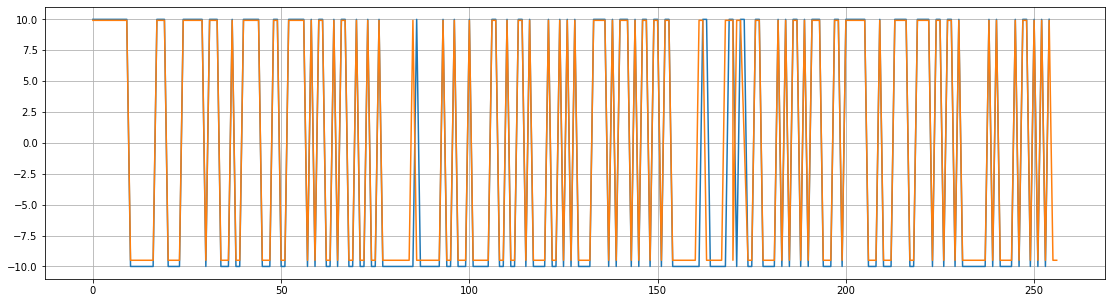

In [9]:
# there could be some data loss
t = (data[:,11] / 0.02).astype(int)
# make sure the input PRBS is correct
plt.figure(figsize = (19,5))
plt.grid()
plt.plot([i for i in range(255)], [10*u[i] for i in range(255)])
plt.plot(t[0:255], data[0:255,9])

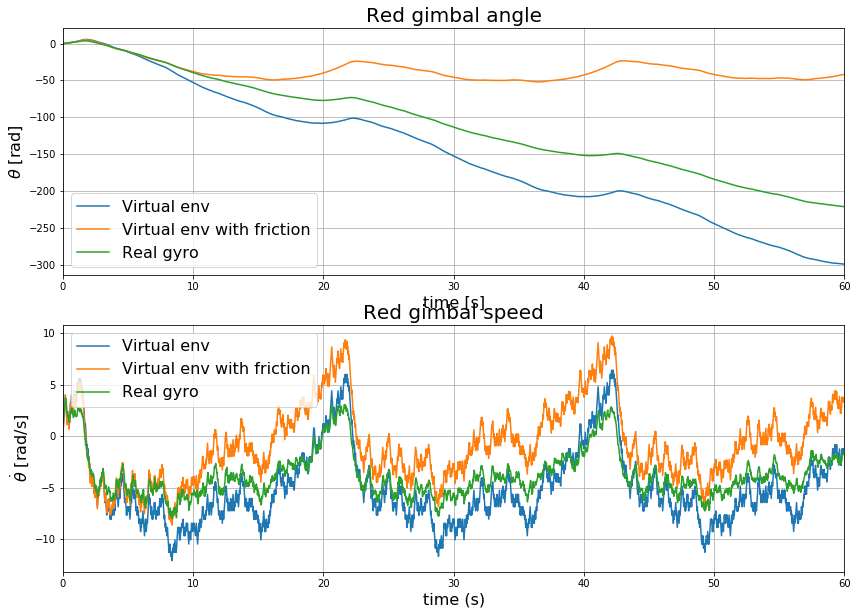

In [10]:
f, axs = plt.subplots(2,1,figsize=(14,10))

plt.subplot(2,1,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0])
plt.plot(time,state_record_f[:,0])
plt.plot(data[:,11], data[:,2]/180*np.pi) # deg to rad
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.subplot(2,1,2)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1])
plt.plot(time,state_record_f[:,1])
plt.plot(data[:,11], data[:,3]*2*np.pi/60) # rpm to rad/s
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.savefig('id_red.png')

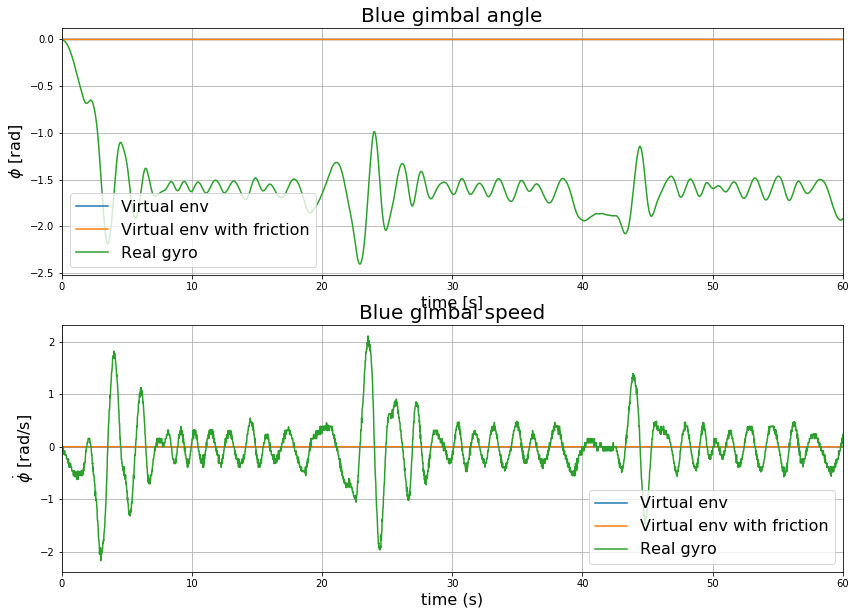

In [11]:
f, axs = plt.subplots(2,1,figsize=(14,10))

plt.subplot(2,1,1)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2])
plt.plot(time,state_record_f[:,2])
plt.plot(data[:,11], data[:,4]/180*np.pi) # deg to rad
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.subplot(2,1,2)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3])
plt.plot(time,state_record_f[:,3])
plt.plot(data[:,11], data[:,5]*2*np.pi/60) # rpm to rad/s
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

# plt.savefig('id_red.png')

# Blue gimbal in virtual env (no friction)

In [12]:
# Initial state
x_0 = [0,0,0,0,0,0,0]
observation = env.reset(x_0)

time = np.arange(0, 60, env.dt)
state_record = np.empty([len(time), len(x_0)])
reward_record = np.empty([len(time), 1])
action_record = np.empty([len(time), 2])

for i in range(len(time)):
    action = [0,u[i]] 
    
    observation, reward, done, info = env.step(action)
    state_record[i] = env.state
    reward_record[i] = reward
    action_record[i] = action

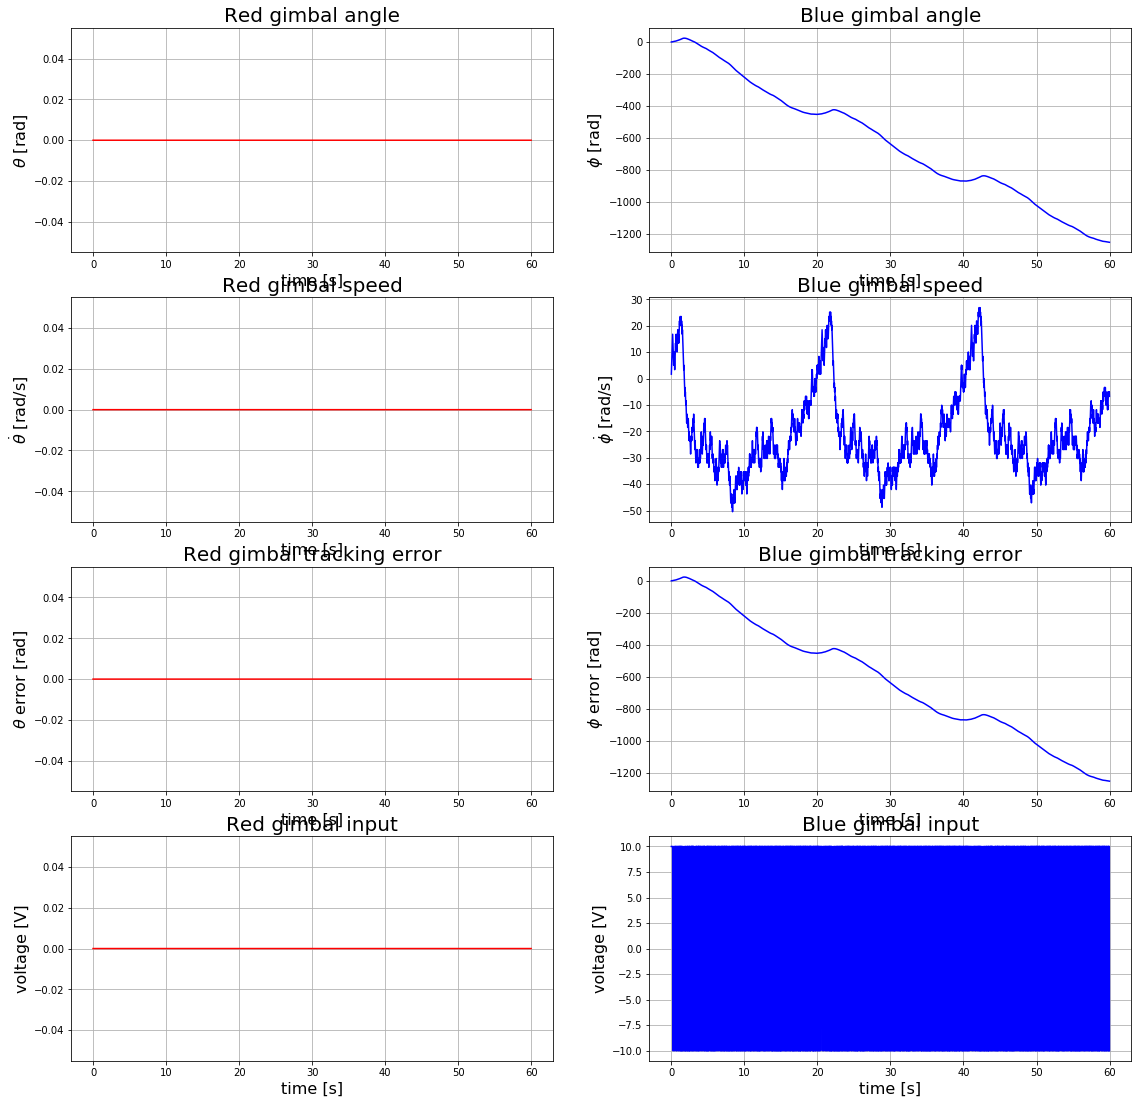

In [13]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0],'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2],'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1],'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3],'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0]-state_record[:,4],'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2]-state_record[:,5],'b-')

plt.subplot(4,2,7)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,0]*10,'r-')

plt.subplot(4,2,8)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,1]*10,'b-')

plt.show()

# Blue gimbal in virtual env (with friction)

In [14]:
# Initial state
x_0 = [0,0,0,0,0,0,0]
observation = env_f.reset(x_0)

time = np.arange(0, 60, env.dt)
state_record_f = np.empty([len(time), len(x_0)])
reward_record_f = np.empty([len(time), 1])
action_record_f = np.empty([len(time), 2])

for i in range(len(time)):
    action = [0,u[i]] 
    
    observation, reward, done, info = env_f.step(action)
    state_record_f[i] = env_f.state
    reward_record_f[i] = reward
    action_record_f[i] = action

# Blue gimbal in real machine

In [15]:
data = read_data('data_blue.txt')

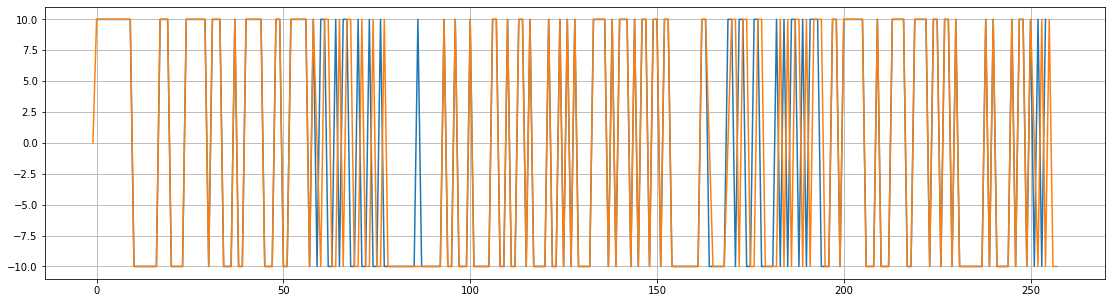

In [16]:
# there could be some data loss
t = np.around(data[:,11] / 0.02)
# make sure the input PRBS is correct
plt.figure(figsize = (19,5))
plt.grid()
plt.plot([i for i in range(255)], [10*u[i] for i in range(255)])
plt.plot(t[0:255]-1, data[0:255,10])

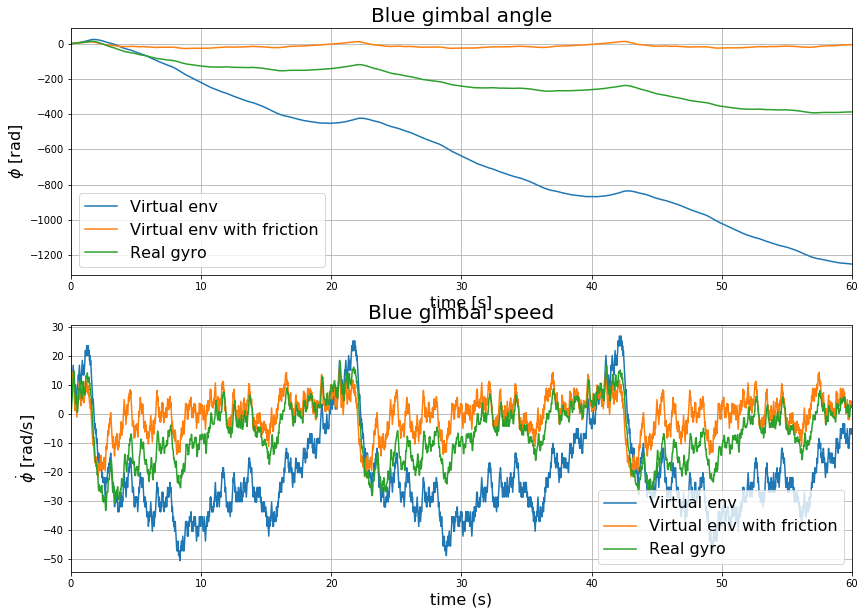

In [17]:
f, axs = plt.subplots(2,1,figsize=(14,10))

plt.subplot(2,1,1)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2])
plt.plot(time,state_record_f[:,2])
plt.plot(data[:,11], data[:,4]/180*np.pi) # deg to rad
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.subplot(2,1,2)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3])
plt.plot(time,state_record_f[:,3])
plt.plot(data[:,11], data[:,5]*2*np.pi/60) # rpm to rad/s
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.savefig('id_blue.png')

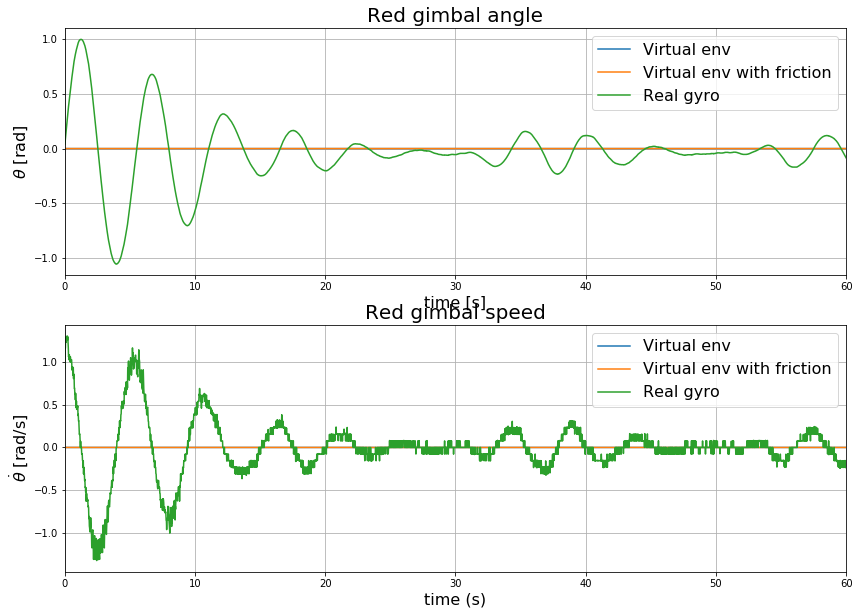

In [18]:
f, axs = plt.subplots(2,1,figsize=(14,10))

plt.subplot(2,1,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0])
plt.plot(time,state_record_f[:,0])
plt.plot(data[:,11], data[:,2]/180*np.pi) # deg to rad
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

plt.subplot(2,1,2)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1])
plt.plot(time,state_record_f[:,1])
plt.plot(data[:,11], data[:,3]*2*np.pi/60) # rpm to rad/s
plt.xlim([0,60])
plt.legend(['Virtual env', 'Virtual env with friction', 'Real gyro'],fontsize=16)

# plt.savefig('id_blue.png')

## Zoom in

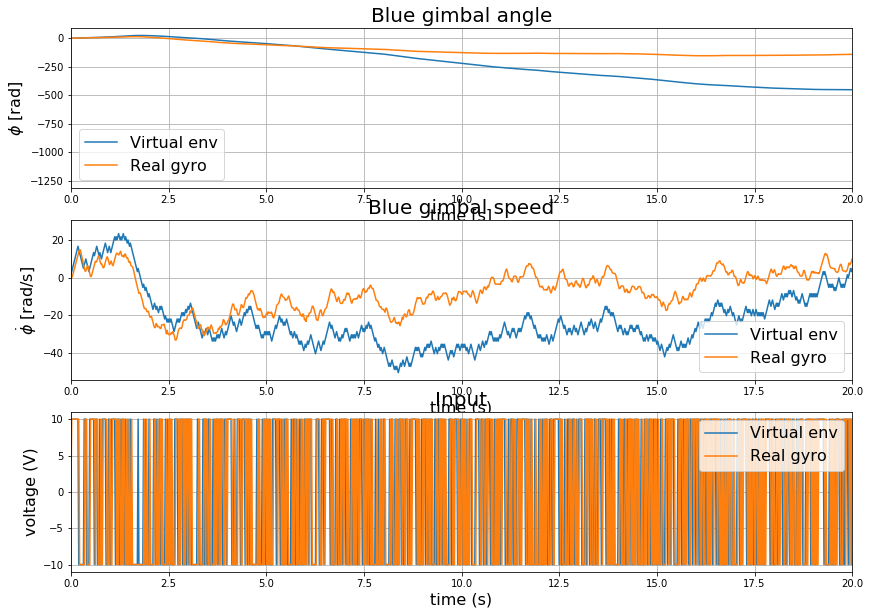

In [19]:
f, axs = plt.subplots(3,1,figsize=(14,10))

t_start = 0
t_end = 20

plt.subplot(3,1,1)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2])
plt.plot(data[:,11], data[:,4]/180*np.pi) # deg to rad
plt.xlim([t_start,t_end])
plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

plt.subplot(3,1,2)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3])
plt.plot(data[:,11], data[:,5]*2*np.pi/60) # rpm to rad/s
plt.xlim([t_start,t_end])
plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

plt.subplot(3,1,3)
plt.title('Input',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u[:len(time)]*10)
plt.plot(data[:,11], data[:,10])
plt.xlim([t_start,t_end])
plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

## Acceleration

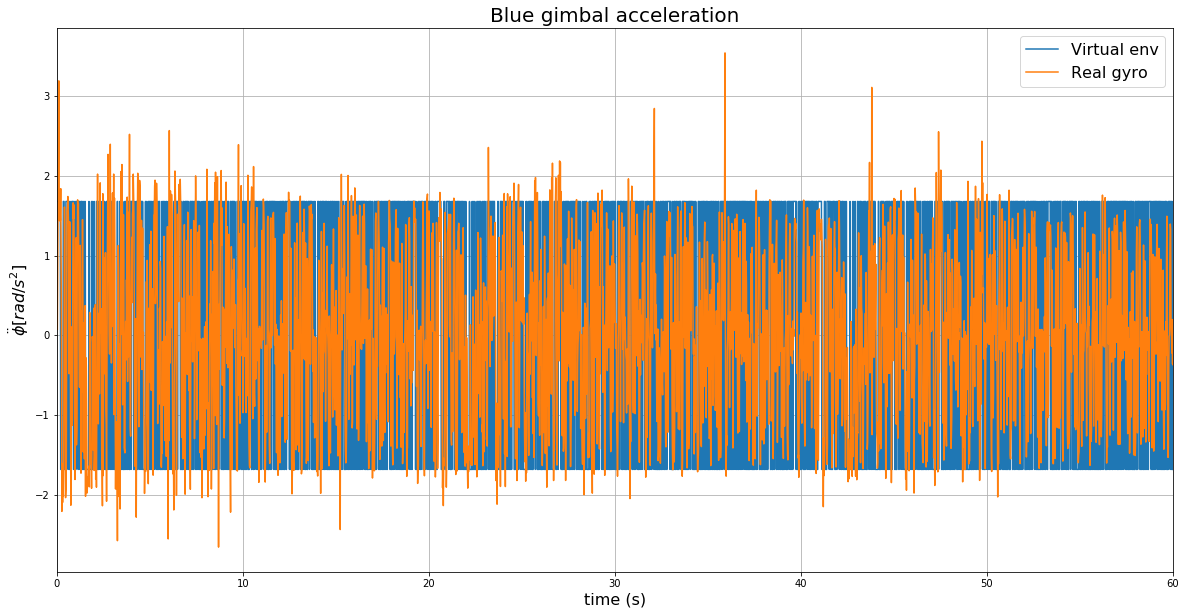

In [20]:
plt.figure(figsize = (20,10))

plt.title('Blue gimbal acceleration',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\ddot \phi [rad/s^2] $',fontsize=16)
plt.grid()
b = state_record[:,3] # velocity in rad/s
plt.plot(time[1:], b[1:]-b[:-1]) # acceleration 
r = data[:,5]*2*np.pi/60 # velocity in rad/s
plt.plot(data[1:,11], r[1:]-r[:-1]) # acceleration
plt.xlim([0,60])
plt.legend(['Virtual env', 'Real gyro'],fontsize=16)